In [4]:
! pip install langgraph

In [5]:
from langgraph.graph import StateGraph

In [6]:
def func1(inp):
  x, y = inp["x"], inp["y"]
  return {"result": x+y}

def func2(inp):
  return {"result": 2 * inp["result"]}

In [7]:
from typing import TypedDict, Annotated
import operator

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        x: int. The first input value.
        y: int. The second input value.
        result: int. The result of the computation.
    """
    x: int
    y: int
    result: Annotated[int, operator.add]


workflow = StateGraph(GraphState)

workflow.add_node("node_1", func1)
workflow.add_node("node_2", func2)

workflow.add_edge("node_1", "node_2")

workflow.set_entry_point("node_1")

app = workflow.compile()

app.invoke({"x": 10, "y": 5})

{'x': 10, 'y': 5, 'result': 45}

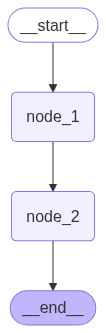

In [8]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# **Query handling work flow of langraph**

# Customer Support App

In [1]:
!pip install langchain langchain_core langchain_groq langchain_community langgraph

In [17]:
!pip install python-dotenv langchain[groq]

In [11]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

In [16]:
from langchain_groq import ChatGroq
from google.colab import userdata

llm = ChatGroq(temperature=0, model_name="llama3-8b-8192", api_key=userdata.get('GROQ_API_KEY'))

In [10]:
from typing_extensions import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [ ]:
class State(TypedDict): # extra type checking wether the values are str or not
  query: str
  category: str
  sentiment: str
  response: str

In [37]:
llm = llm
llm.invoke("what is langchain")

AIMessage(content="LangChain is a cutting-edge AI technology that enables natural language processing (NLP) and machine learning (ML) capabilities. It's a type of large language model (LLM) that's designed to understand and generate human-like language, making it a powerful tool for various applications.\n\nLangChain is built upon the foundation of transformer architecture, which is a type of neural network that's particularly well-suited for NLP tasks. It's trained on massive amounts of text data, allowing it to learn patterns, relationships, and context within language.\n\nSome of the key features and capabilities of LangChain include:\n\n1. **Language understanding**: LangChain can comprehend complex sentences, nuances of language, and even idioms, making it an excellent tool for natural language processing.\n2. **Text generation**: It can generate human-like text, including articles, stories, and even entire books.\n3. **Conversational AI**: LangChain can engage in natural-sounding

In [31]:
from typing_extensions import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

class State(TypedDict): # extra type checking wether the values are str or not
  query: str
  category: str
  sentiment: str
  response: str

def categroize(state: State)->State:
  prompt = ChatPromptTemplate.from_template("Categorize the follwing query into one of the following categroies:"
  "Technical, Billing, General, Query:{query}")
  chain = prompt |llm
  category = chain.invoke({"query": state["query"]}).content
  print(f"\nCategory: {category}")
  return {"category": category}

def analyze_sentiment(state: State)->State:
  print("\nAnalyzing the sentiment: ")
  prompt = ChatPromptTemplate.from_template(
       "Analyze the sentiment of the following customer query and ans in word"
       "Response with either Positive', 'Neutral', or 'Negative. Query: {query}"
)

  chain = prompt | llm
  sentiment = chain.invoke({"query": state["query"]}).content
  print(f"\nSentiment: {sentiment}")
  return {"sentiment": sentiment}

def handle_technical(state: State)->State:
  print("\nHandling the technical query")
  prompt = ChatPromptTemplate.from_template(
      "Provide a technical support response to the following query: {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def handle_billing(state: State)->State:
  print("\nHandling the billing query")
  prompt = ChatPromptTemplate.from_template(
      "Provide a billing support response to the following query: {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def handle_general(state: State)->State:
  print("\nHandling the general query")
  prompt = ChatPromptTemplate.from_template(
      "Provide a general support response to the following query: {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def escalate(state: State)->State:
  print("Escalating the query")
  return{"response": "This quey has been escalte to a human agent due to its -ve sentiment"}

def route_query(state: State)->State:
  if state["sentiment"] == "Negative":
    return "escalate"
  elif state["category"] == "Technical":
    return "handle_technical"
  elif state["category"] == "Billing":
    return "handle_billing"
  else:
    return "handle_general"

In [34]:
workflow = StateGraph(State)

workflow.add_node("categroize", categroize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

workflow.add_conditional_edges("analyze_sentiment", route_query, {
    "handle_technical": "handle_technical",
    "handle_billing": "handle_billing",
    "handle_general": "handle_general",
    "escalate": "escalate",
})

workflow.add_edge("categroize", "analyze_sentiment")
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

workflow.set_entry_point("categroize")

app = workflow.compile()

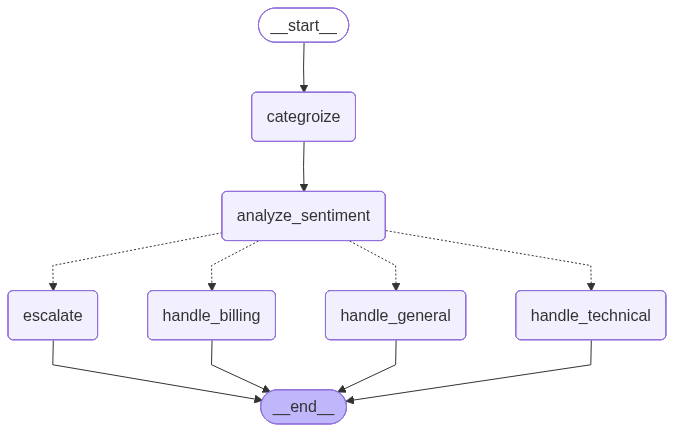

In [35]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [38]:
def run_customer_support(query: str)-> Dict[str, str]:
   results = app.invoke({"query": query})
   return {
    "category":results['category'],
    "sentiment": results["sentiment"],
    "response": results["response"]
}

In [39]:
query = "The price value in my invoice is wrong"
result = run_customer_support(query)
print("\n\n\nComputed Result")
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


Category: I would categorize this query as "Billing".

Analyzing the sentiment: 

Sentiment: Sentiment Analysis: Negative

Reason: The customer is expressing dissatisfaction with the price value in their invoice, which implies that they are unhappy with the service or product they received. The tone is straightforward and to the point, indicating a negative sentiment.

Handling the general query



Computed Result
Query: The price value in my invoice is wrong
Category: I would categorize this query as "Billing".
Sentiment: Sentiment Analysis: Negative

Reason: The customer is expressing dissatisfaction with the price value in their invoice, which implies that they are unhappy with the service or product they received. The tone is straightforward and to the point, indicating a negative sentiment.
Response: Here's a general support response to the query:

Dear [Customer],

Thank you for bringing this to our attention. We apologize for the inconvenience and are here to help resolve the i

In [40]:
query = "I am really happy with the serviece adn i want invoice for my new purchase"
result = run_customer_support(query)
print("\n\n\nComputed Result")
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


Category: I would categorize this query as "Billing". The customer is requesting an invoice for their new purchase, which is a billing-related inquiry.

Analyzing the sentiment: 

Sentiment: Sentiment Analysis: Positive

Reasoning: The customer starts by expressing their happiness with the service, which is a positive sentiment. They then request an invoice for their new purchase, which is a neutral request. Overall, the tone of the query is positive, as the customer is expressing satisfaction with the service.

Handling the general query



Computed Result
Query: I am really happy with the serviece adn i want invoice for my new purchase
Category: I would categorize this query as "Billing". The customer is requesting an invoice for their new purchase, which is a billing-related inquiry.
Sentiment: Sentiment Analysis: Positive

Reasoning: The customer starts by expressing their happiness with the service, which is a positive sentiment. They then request an invoice for their new purchas

In [41]:
query = "I dint like the product can i get the refund back"
result = run_customer_support(query)
print("\n\n\nComputed Result")
print(f"\nQuery: {query}")
print(f"\nCategory: {result['category']}")
print(f"\nSentiment: {result['sentiment']}")
print(f"\nResponse: {result['response']}")
print("\n")


Category: I would categorize this query as "General". The query is not related to a specific technical issue, billing process, or a specific product feature, but rather a customer expressing dissatisfaction with a product and requesting a refund.

Analyzing the sentiment: 

Sentiment: Sentiment Analysis: **Negative**

Reasoning: The customer explicitly states that they "didn't like" the product, which indicates a negative sentiment. Additionally, they are requesting a refund, which further reinforces the negative sentiment.

Handling the general query



Computed Result

Query: I dint like the product can i get the refund back

Category: I would categorize this query as "General". The query is not related to a specific technical issue, billing process, or a specific product feature, but rather a customer expressing dissatisfaction with a product and requesting a refund.

Sentiment: Sentiment Analysis: **Negative**

Reasoning: The customer explicitly states that they "didn't like" the 